<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Декомпозиция-временных-рядов" data-toc-modified-id="Декомпозиция-временных-рядов-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Декомпозиция временных рядов</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Изучение-коллинеарности-признаков" data-toc-modified-id="Изучение-коллинеарности-признаков-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Изучение коллинеарности признаков</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Деление-данных-на-выборки" data-toc-modified-id="Деление-данных-на-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Деление данных на выборки</a></span></li><li><span><a href="#Нормирование-признаков" data-toc-modified-id="Нормирование-признаков-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Нормирование признаков</a></span></li><li><span><a href="#Модель-Ridge:" data-toc-modified-id="Модель-Ridge:-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель Ridge:</a></span></li><li><span><a href="#модель-LightGBM:" data-toc-modified-id="модель-LightGBM:-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>модель LightGBM:</a></span></li><li><span><a href="#модель-CatBoostREgressor:" data-toc-modified-id="модель-CatBoostREgressor:-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>модель CatBoostREgressor:</a></span></li><li><span><a href="#модель-DecisionTreeRegressor:" data-toc-modified-id="модель-DecisionTreeRegressor:-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>модель DecisionTreeRegressor:</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Визуализация-результата" data-toc-modified-id="Визуализация-результата-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Визуализация результата</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

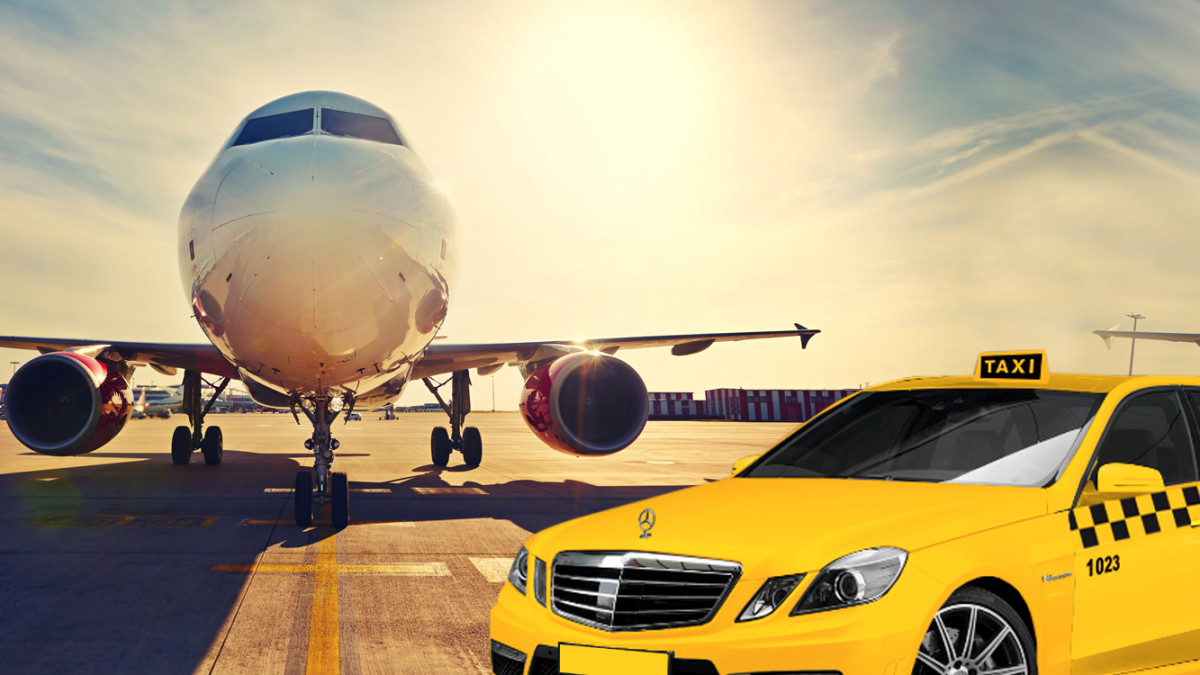

#  Прогнозирование заказов такси

Для выполнения проекта предоставлены исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка данных

In [1]:
%%capture --no-display 
!pip install catboost

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor



import warnings
warnings.filterwarnings("ignore")

#глобальные переменные:

NJOBS = -1 # для одновременной работы всех ядер процессора при обучении моделей(для увеличения скорости) 
RANDOM = 12345
ITERATIONS = 10 #grid search iteration

**Загрузим данные и сделаем их ресэмплирование по одному часу:**

Импорт рабочего датасета не показан в соответствии с политикой конфиденциальности ЯП.

In [3]:
# посмотрим общие данные об датасете:

data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [4]:
# проверим на пропуски:

data.isna().sum()

num_orders    0
dtype: int64

In [5]:
#первые 10 строк :

data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [6]:
# отсортируем индекс:

data.sort_index(inplace=True)

In [7]:
# проверим индекс на хронологический порядок:

data.index.is_monotonic

True

In [8]:
# проведем ресемплирование по 1 часу:

data = data.resample('1H').sum()

In [9]:
# посмотрим на данные сейчас:

data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


**Данные ресемплированы по 1 часу.**

In [10]:
# посмотрим начальную и конечную даты наблюдений:

print('Дата начала наблюдений: {}'.format(data.index.min()))
print('Дата окончания наблюдений: {}'.format(data.index.max()))
print('Временной отрезок: {}'.format(data.index.max() - data.index.min()))

Дата начала наблюдений: 2018-03-01 00:00:00
Дата окончания наблюдений: 2018-08-31 23:00:00
Временной отрезок: 183 days 23:00:00


**Отобразим визуально гистограмму по данным:**

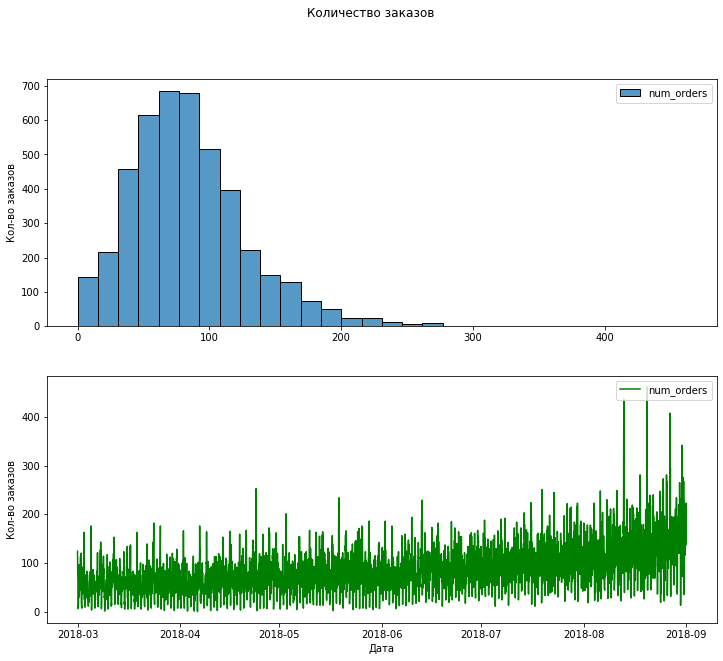

In [11]:
plt.figure(figsize=(12,10))
plt.subplot(211)
sns.histplot(data, bins=30)
plt.ylabel('Кол-во заказов')
plt.suptitle('Количество заказов')

plt.subplot(212)
sns.lineplot(x=data.index, y=data['num_orders'],
             ax=plt.gca(),
             label = 'num_orders',
             color='green');
plt.ylabel('Кол-во заказов')
plt.legend(prop={'size': 10}, loc='upper right')
plt.xlabel('Дата');

**Вывод:**
- данные загружены и изучены. Наблюдения проводились с 1 марта 2018г. по 31 августа 2018г. (на протяжении 5 месяцев).
- фиксируем отсутствие пропусков и аномалий.
- данные ресемплированы по одному часу.
- согласно гистограмме, распределение приближено к нормальному и наблюдается общее плавное увеличение заказов.


## Анализ

### Декомпозиция временных рядов

In [12]:
decomposed_data = seasonal_decompose(data)

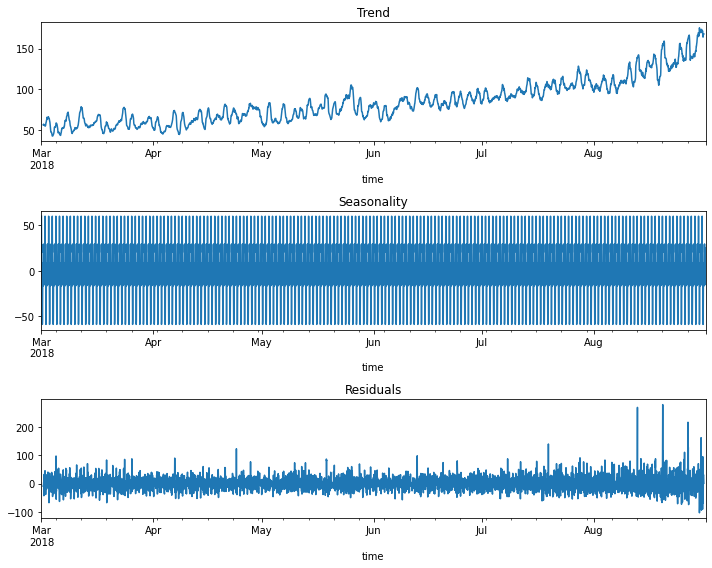

In [13]:
plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed_data.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('time')

plt.subplot(312)
decomposed_data.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.xlabel('time')

plt.subplot(313)
decomposed_data.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.xlabel('time')
plt.tight_layout()

**Самой "стабильной" компонентой оказалась сезонность, поэтому рассмотрим ее более детально, разложив на дневной, недельный и месячный интервалы:**

Text(0.5, 0, 'per_month')

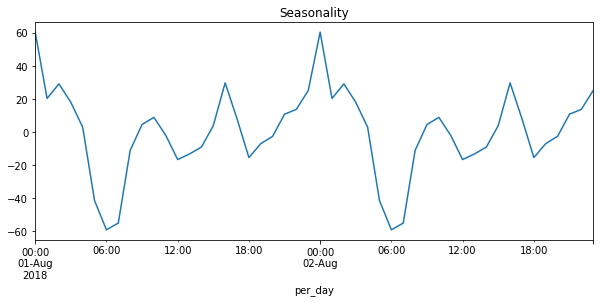

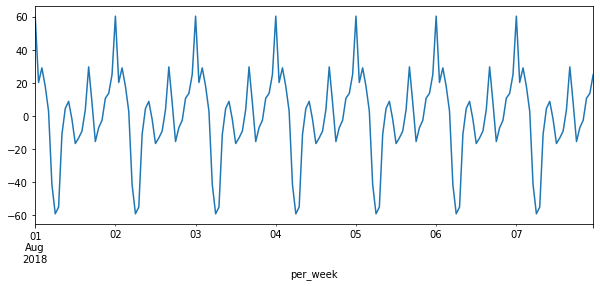

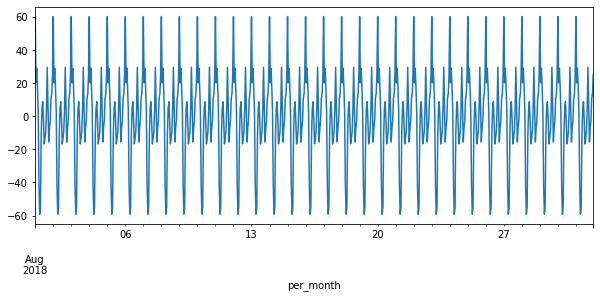

In [14]:
plt.figure(figsize=(10, 4))
decomposed_data.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca()) 
plt.title('Seasonality');
plt.xlabel('per_day')

plt.figure(figsize=(10, 4))
decomposed_data.seasonal['2018-08-01':'2018-08-07'].plot(ax=plt.gca()) 
plt.xlabel('per_week')

plt.figure(figsize=(10, 4))
decomposed_data.seasonal['2018-08-01':'2018-09-01'].plot(ax=plt.gca()) 
plt.xlabel('per_month')

**Вывод:**
 - разложили временной ряд на компоненты и построили графики.
 - согласно графику, тренд стабильно идет вверх, среднее растет.
 - кол-во шума в данных пропорционально кол-ву самих данных, что очень логично и не требует более глубокого изучения.
 - изучили сезонность более подробно и в ней наблюдаем следующее:
    - кол-во заказов по часам суток совпадает с час-пиком: меньше всего заказов в 6 утра, начиная с 18.00 их кол-во           возрастает, достигая пика в 23-00 чч.
    - по дням недели и в пределах одного месяца кол-во заказов визуально совпадает.
   

### Создание признаков 

In [15]:
# функция для создания признаков:

def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    

**Возьмем для отображения лага 24-ой интервал, из-за сильно выраженной суточной сезонности**

In [16]:
make_features(data, 24, 10)    
    
data.head()    

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# удалим пропуски:

data = data.dropna()

data.head()

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,61.7
2018-03-02 01:00:00,120,3,2,4,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,65.9
2018-03-02 02:00:00,75,3,2,4,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,71.3
2018-03-02 03:00:00,64,3,2,4,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,74.5
2018-03-02 04:00:00,20,3,2,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,76.5


### Изучение коллинеарности признаков

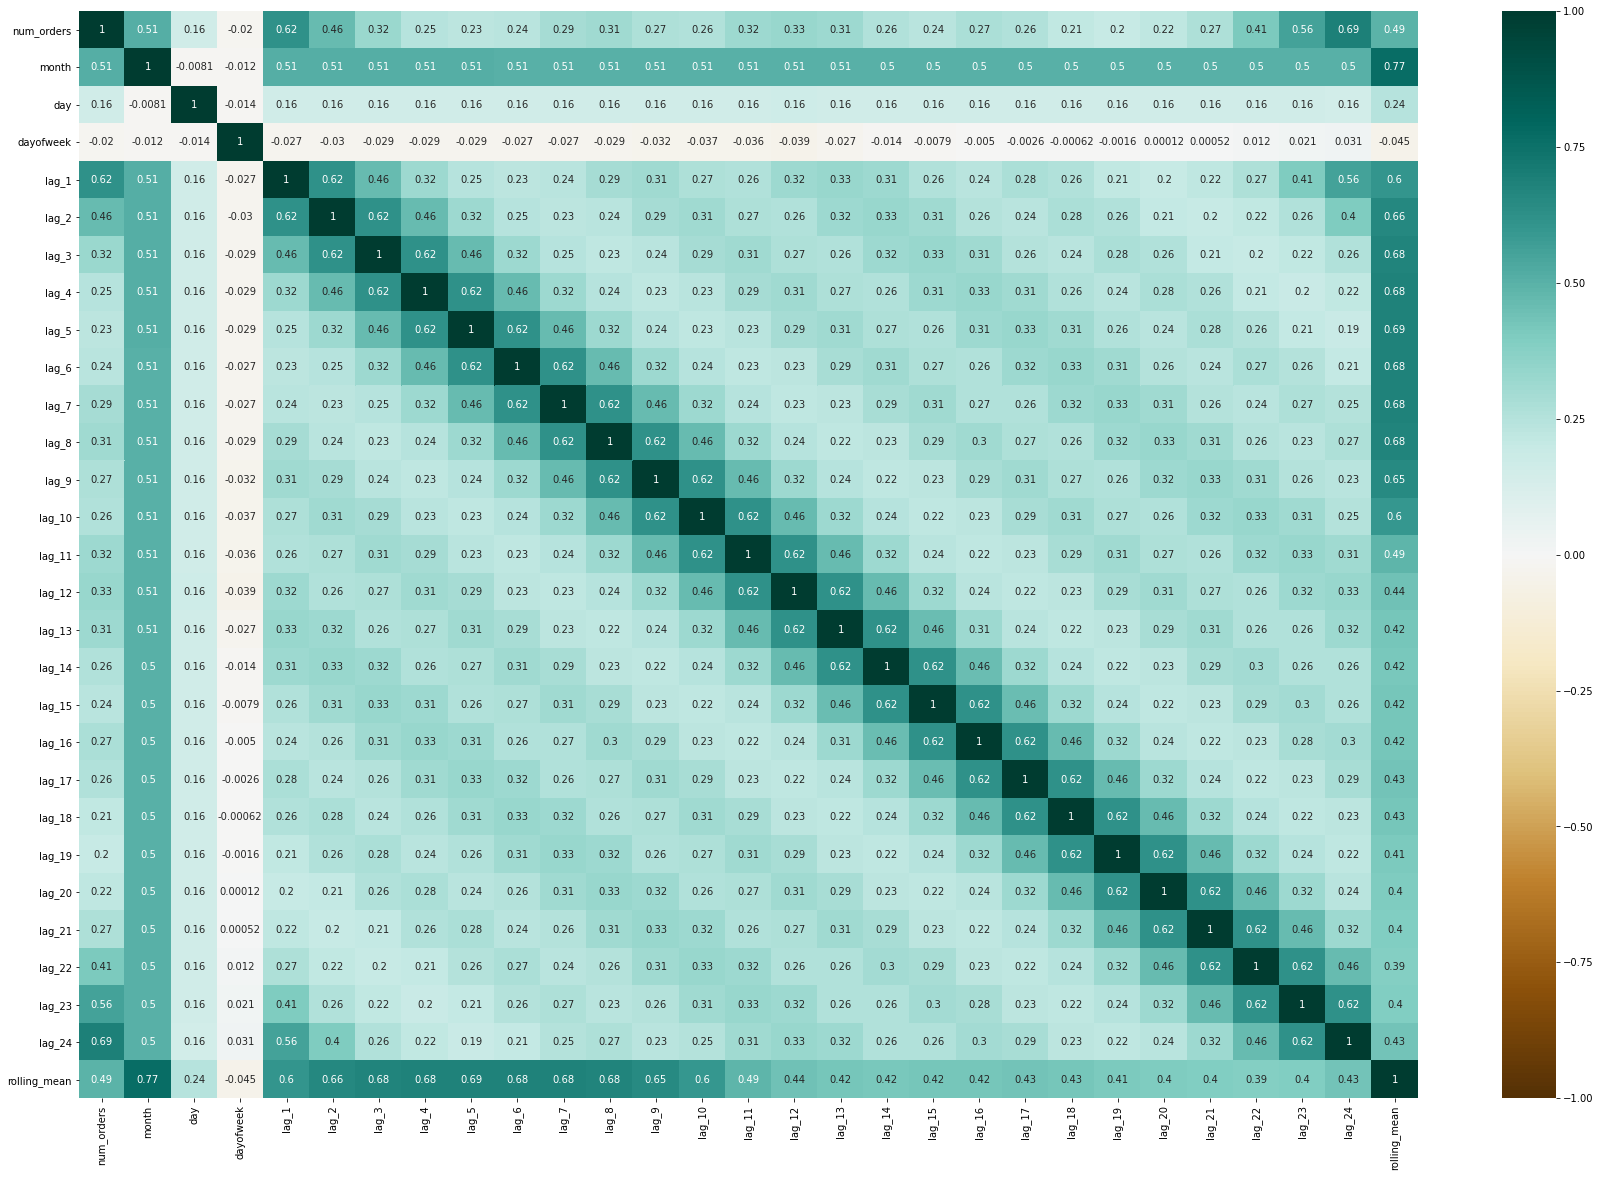

In [18]:
plt.figure(figsize=(30,20))
sns.heatmap(
    data.corr(),        
    cmap='BrBG', # задаёт цветовую схему
    annot=True, # рисует значения внутри ячеек
    vmin=-1, vmax=1); # указывает начало цветовых кодов от -1 до 1.

**Между признаками имеeтся положительная корреляция, но явно коллинеарных с R > 0.9 не обнаружено. Таким образом оставляем все признаки для дальнейшей работы.**

## Обучение

### Деление данных на выборки

In [19]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [20]:
train_features = train.drop(['num_orders'], axis=1)

test_features = test.drop(['num_orders'], axis=1)

train_target = train['num_orders']

test_target = test['num_orders']

train_features.shape, train_target.shape, test_features.shape, test_target.shape

((3952, 28), (3952,), (440, 28), (440,))

In [21]:
# минимльные и максимальные индексы выборок, чтобы убедиться, что выборки разделены в хронологич.порядке:

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


### Нормирование признаков

Т.к. в датасете только числовые признаки, применим StandardScaler:

In [22]:
sc =  StandardScaler()
sc.fit(train_features)

StandardScaler()

In [23]:
train_features = pd.DataFrame(sc.transform(train_features), columns=train_features.columns) 
test_features = pd.DataFrame(sc.transform(test_features), columns=test_features.columns)

train_features.head(10)

,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
0,-1.424409,-1.494599,0.485927,-0.528019,0.893921,-0.320922,-0.450002,-0.863303,-0.138632,-0.888637,...,-1.158687,-1.658000,-1.735774,-1.892353,-0.919243,-0.314539,-0.183060,0.185170,1.211019,-0.718084
1,-1.424409,-1.494599,0.485927,0.299361,-0.528062,0.894380,-0.320716,-0.449476,-0.863199,-0.138050,...,-0.238808,-1.158312,-1.656894,-1.734622,-1.891852,-0.919127,-0.314491,-0.182881,0.185419,-0.537168
2,-1.424409,-1.494599,0.485927,1.075030,0.299273,-0.527782,0.894574,-0.320155,-0.449161,-0.862755,...,-0.370219,-0.237833,-1.157327,-1.655756,-1.734131,-1.891724,-0.919076,-0.314328,-0.182744,-0.304561
3,-1.424409,-1.494599,0.485927,-0.088473,1.074900,0.299658,-0.527574,0.895464,-0.319774,-0.448638,...,0.470813,-0.369330,-0.237070,-1.156273,-1.655271,-1.734006,-1.891670,-0.918983,-0.314232,-0.166720
4,-1.424409,-1.494599,0.485927,-0.372885,-0.088540,1.075383,0.299858,-0.527069,0.896462,-0.319226,...,-1.263816,0.472251,-0.368535,-0.236172,-1.155824,-1.655146,-1.733952,-1.891689,-0.919072,-0.080569
5,-1.424409,-1.494599,0.485927,-1.510533,-0.372937,-0.088205,1.075575,0.300587,-0.526793,0.897243,...,-1.211252,-1.263509,0.472842,-0.367615,-0.235789,-1.155704,-1.655093,-1.733953,-1.892077,-0.308868
6,-1.424409,-1.494599,0.485927,-1.743234,-1.510523,-0.372637,-0.088001,1.076513,0.301283,-0.526285,...,-0.790735,-1.210910,-1.262499,0.473621,-0.367222,-0.235680,-1.155653,-1.655085,-1.734292,-0.455324
7,-1.424409,-1.494599,0.485927,-1.743234,-1.743211,-1.510367,-0.372431,-0.087377,1.077604,0.301949,...,-0.317655,-0.790120,-1.209913,-1.261427,0.473952,-0.367112,-0.235632,-1.155587,-1.655400,-0.670701
8,-1.424409,-1.494599,0.485927,-1.846656,-1.743211,-1.743085,-1.510149,-0.371883,-0.086878,1.078419,...,-0.922147,-0.316731,-0.789224,-1.208850,-1.260970,0.474053,-0.367064,-0.235460,-1.155749,-0.924846
9,-1.424409,-1.494599,0.485927,-0.838287,-1.846628,-1.743085,-1.742865,-1.509909,-0.371529,-0.086285,...,-0.895864,-0.921617,-0.315949,-0.788232,-1.208397,-1.260850,0.474098,-0.366907,-0.235339,-1.213450


### Модель Ridge:

**Т.к. производим кросс-валидацию для временных рядов, то нельзя, чтобы она проходила на тестовой выборке впереди тренировочной.
Поэтому создадим объект TimeSeriesSplit():**

In [24]:
tscv = TimeSeriesSplit(n_splits=5)

In [25]:
ridge_model = Ridge(random_state=RANDOM)

In [26]:
# Для поиска лучших параметров модели,
# применим GridSearchCV, который имеет встроенную кросс-валидацию для модели Ridge

# создаем словарь гиперпараметров:
gs_param= {
    'alpha': np.arange(0, 0.25, 0.01),
}

# Получение лучшей модели после выполнения поиска по сетке
# best_model = clf_grid.best_estimator_


# объект GridSearchCV:
gs_ridge = GridSearchCV(
    ridge_model,
    cv=tscv,
    param_grid=gs_param, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=NJOBS
)

In [27]:
# обучим GridSearchCV на тренировочной выборке:
gs_ridge.fit(train_features, train_target)

# лучшее значение RMSE на кросс-валидации
print(f'best RMSE score: {gs_ridge.best_score_ * -1}')

# лучшие гиперпараметры
print(f'best params: {gs_ridge.best_params_}')

best RMSE score: 27.02648831172051
best params: {'alpha': 0.24}


In [28]:
 # из атрибута GridSearchCV  `с_results_` извлечем максимальное время обучения :   
ridge_fit_time = gs_ridge.cv_results_['mean_fit_time'].max()
ridge_fit_time


0.14969210624694823

In [29]:
# и предсказания:
ridge_score_time = gs_ridge.cv_results_['mean_score_time'].max()
ridge_score_time


0.07495079040527344

In [30]:
# Получение лучшей модели после выполнения поиска по сетке:

best_model_ridge = gs_ridge.best_estimator_
best_model_ridge

Ridge(alpha=0.24, random_state=12345)

### модель LightGBM:

In [31]:
# создание модели lgbm:
lgbm_model = LGBMRegressor(random_state=RANDOM, n_jobs=NJOBS)

In [32]:
# список гиперпараметров:

params = {
              'num_leaves':[5, 10, 20, 30],
              'min_child_samples': [10, 50, 100, 150],
              'max_depth': [3, 8, 12, 15],
              'learning_rate': [0.01, 0.05, 0.15, 0.3]}

In [33]:
# объект RandomizedSearchCV для поиска наилучших гиперпараметров:

lgbm_rs = RandomizedSearchCV(estimator=lgbm_model,
                            param_distributions=params,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=NJOBS,
                            cv=tscv,
                            random_state=RANDOM,
                            n_iter=ITERATIONS)

In [34]:
# обучим lgbm_rs на трейновой выборке:

lgbm_rs.fit(train_features, train_target)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=LGBMRegressor(random_state=12345), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.15,
                                                          0.3],
                                        'max_depth': [3, 8, 12, 15],
                                        'min_child_samples': [10, 50, 100, 150],
                                        'num_leaves': [5, 10, 20, 30]},
                   random_state=12345, scoring='neg_root_mean_squared_error')

In [35]:
# лучшие гиперпараметры:

lgbm_rs_best_score = lgbm_rs.best_score_ * -1
lgbm_rs_best_params = lgbm_rs.best_params_

print(f'best_score: {lgbm_rs_best_score}')
print(f'best_params: {lgbm_rs_best_params}')

best_score: 25.623142352380455
best_params: {'num_leaves': 30, 'min_child_samples': 10, 'max_depth': 12, 'learning_rate': 0.05}


In [36]:
 # из атрибута GridSearchCV  `с_results_` извлечем максимальное время обучения:   
lgbm_fit_time = lgbm_rs.cv_results_['mean_fit_time'].max()
lgbm_fit_time

2.156704473495483

In [37]:
# и предсказания:

lgbm_score_time = lgbm_rs.cv_results_['mean_score_time'].max()
lgbm_score_time

0.056738758087158205

In [38]:
# лучшая модель после поиска по сетке:

best_model_lgbm = lgbm_rs.best_estimator_
best_model_lgbm

LGBMRegressor(learning_rate=0.05, max_depth=12, min_child_samples=10,
              num_leaves=30, random_state=12345)

### модель CatBoostREgressor:

In [39]:
# создадим модель Катбуста:

model_cbr = CatBoostRegressor(loss_function='RMSE',
                              task_type='CPU',
                              verbose=False,
                              random_state=RANDOM)

In [40]:
# список гиперпараметров:

param_cbr = {
    'iterations': range(300, 901, 150),
    'learning_rate': [0.01, 0.03, 0.05],
    'depth': range(2, 11, 2),
    'reg_lambda': [1, 5, 10]
}

In [41]:
# использование RandomizedSearchCV для поиска наилучших гиперпараметров:

cbr_rs = RandomizedSearchCV(estimator= model_cbr,
                            param_distributions=param_cbr,
                            scoring='neg_root_mean_squared_error',   
                            n_iter=ITERATIONS,
                            verbose=False,
                            n_jobs=NJOBS,
                            cv=tscv)

In [42]:
# обучим объект RandomizedSearchCV на трейновой выборке:

cbr_rs.fit(train_features, train_target)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f3c74eb6400>,
                   n_jobs=-1,
                   param_distributions={'depth': range(2, 11, 2),
                                        'iterations': range(300, 901, 150),
                                        'learning_rate': [0.01, 0.03, 0.05],
                                        'reg_lambda': [1, 5, 10]},
                   scoring='neg_root_mean_squared_error', verbose=False)

In [43]:
# лучшие гиперпараметры:

cbr_rs_best_score = cbr_rs.best_score_ * -1
cbr_rs_best_params = cbr_rs.best_params_
print(f'best_score: {cbr_rs_best_score}')
print(f'best_params: {cbr_rs_best_params}')

best_score: 24.9030963209987
best_params: {'reg_lambda': 10, 'learning_rate': 0.03, 'iterations': 750, 'depth': 6}


In [44]:
 # из атрибута GridSearchCV  `с_results_` извлечем максимальное время обучения: 
    
cbr_fit_time = cbr_rs.cv_results_['mean_fit_time'].max()
cbr_fit_time

38.11108546257019

In [45]:
# и предсказания:

cbr_score_time = cbr_rs.cv_results_['mean_score_time'].max()
cbr_score_time

0.0060862541198730465

In [46]:
# лучшая модель CatBoostREgressor:

best_model_cbr = cbr_rs.best_estimator_
best_model_cbr

### модель DecisionTreeRegressor:

In [47]:
dt_model = DecisionTreeRegressor(random_state=RANDOM)

In [48]:
# словарь с гиперпараметрами для модели DecisionTree:

dt_param = {'splitter': ['best', 'random'],                          #default='best'
            'max_depth': [i for i in range(3, 42, 5)],               #default=None
            'min_samples_leaf': [i for i in range(1, 25)],           #default=1
            'max_leaf_nodes': [None]+[10*i for i in range(1, 31)]    #default=None
              
}

In [49]:
# поиск наилучших гиперпараметров по RandomizedSearchCV:

dt_rs = RandomizedSearchCV(dt_model,
                           param_distributions=dt_param,
                           scoring='neg_root_mean_squared_error',
                           cv=tscv,
                           n_jobs=-1,
                           random_state=RANDOM
                          )

In [50]:
# обучим объект RandomizedSearchCV:

dt_rs.fit(train_features, train_target)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=DecisionTreeRegressor(random_state=12345),
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 8, 13, 18, 23, 28, 33,
                                                      38],
                                        'max_leaf_nodes': [None, 10, 20, 30, 40,
                                                           50, 60, 70, 80, 90,
                                                           100, 110, 120, 130,
                                                           140, 150, 160, 170,
                                                           180, 190, 200, 210,
                                                           220, 230, 240, 250,
                                                           260, 270, 280, 290, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                        

In [51]:
# лучшие гиперпараметры модели:

dt_rs_best_score = dt_rs.best_score_ * -1
dt_rs_best_params = dt_rs.best_params_

print(f'best_score: {dt_rs_best_score}')
print(f'best_params: {dt_rs_best_params}')


best_score: 28.949301089626278
best_params: {'splitter': 'random', 'min_samples_leaf': 15, 'max_leaf_nodes': 50, 'max_depth': 28}


In [52]:
 # из атрибута RandomizedSearchCV  `с_results_` извлечем максимальное время обучения:
    
tree_fit_time = dt_rs.cv_results_['mean_fit_time'].max()
tree_fit_time 

0.03239731788635254

In [53]:
 # и предсказания:
    
tree_score_time = dt_rs.cv_results_['mean_score_time'].max()
tree_score_time
    


0.002070903778076172

In [54]:
# лучшая модель DecisionTreeREgressor:

best_model_dt = dt_rs.best_estimator_
best_model_dt

DecisionTreeRegressor(max_depth=28, max_leaf_nodes=50, min_samples_leaf=15,
                      random_state=12345, splitter='random')

**Отобразим скоры всех моделей в общей таблице:**

In [55]:
whole_param = {'RMSE': [-gs_ridge.best_score_, -lgbm_rs.best_score_, -cbr_rs.best_score_, -dt_rs.best_score_],
       'max_time_fit':[ridge_fit_time, lgbm_fit_time, cbr_fit_time, tree_fit_time],
       'max_time_score':[ridge_score_time, lgbm_score_time, cbr_score_time, tree_score_time]}


result = pd.DataFrame(whole_param,  index=['Ridge','LGBMRegresor','CatBoostREgressor', 'DecisionTreeRegressor'])

round(result, 3)


,RMSE,max_time_fit,max_time_score
Ridge,27.026,0.150,0.075
LGBMRegresor,25.623,2.157,0.057
CatBoostREgressor,24.903,38.111,0.006
DecisionTreeRegressor,28.949,0.032,0.002


**Вывод:**
 - разделили данные на выборки.
 - провели нормирование признаков с помощью SatndardScaler.
 - обучили 4 модели `Ridge`, `LGBMRegresor`, `CatBoostREgressor`, `DecisionTreeRegressor`.
 - у всех моделей целевая метрика RMSE значительно меньше 48, однако выбрали как наилучшую модель LGBMRegresor
 (самый маленький RMSE и довольно быстрая).

## Тестирование

**В предыдущем пункте выбрали модель  LGBMRegresor, проведем ее тестирование:**

In [56]:

prediction = best_model_lgbm.predict(test_features)

RMSE = mean_squared_error(test_target, prediction, squared=False)

print('RMSE лучшей модели LGBMRegresor = ', round(RMSE))


RMSE лучшей модели LGBMRegresor =  41


**посмотрим модель на DummyRegressor:**

In [57]:
dr = DummyRegressor(strategy='mean')
dr.fit(train_features, train_target)

print('RMSE = ', mean_squared_error(test_target, dr.predict(test_features))**0.5)

RMSE =  84.68768287118466


**Видим, что RMSE лучшей модели LGBMRegresor = 41, что значительно меньше требуемого( RMSE<=48 ).</br> По сравнению с RMSE = 85
на DummyRegressor, модель выглядит адекватно.**

### Визуализация результата

In [58]:
result = np.array([best_model_lgbm.predict(test_features), test_target])
result = pd.DataFrame(result.T, columns=['LGBM', 'fact'], index=test_target.index)
result

,LGBM,fact
datetime,,
2018-08-13 16:00:00,149.382770,144.0
2018-08-13 17:00:00,152.710783,152.0
2018-08-13 18:00:00,99.028542,104.0
2018-08-13 19:00:00,100.947373,91.0
2018-08-13 20:00:00,106.053758,82.0
...,...,...
2018-08-31 19:00:00,139.917204,136.0
2018-08-31 20:00:00,189.509502,154.0
2018-08-31 21:00:00,183.215445,159.0


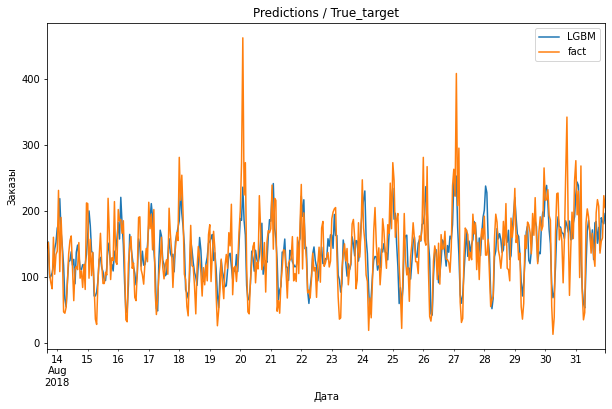

In [59]:
# построим график предсказания лучшей модели и фактические значения на одних осях: 

result.plot(figsize=(10, 6),
         title = 'Predictions / True_target',
         ylabel = 'Заказы',
         xlabel = 'Дата');

**В целом модель предсказывает более "усредненно", не учитывая выбросы в реальных значениях таргета.**

## Общий вывод

- В результате работы, загрузили и исследовали датасет о заказах такси во времени.
- Данные исследованы на наличие пропусков, дубликатов, хронологическую запись данных.
- Проведено ресемплирование выборки по 1 часу.
- Созданы новые численные признаки из содержащихся в DateTime-формате.
- Признаки приведены к единому инструментом StandardScaler.
- Датасет разбит на обучающую и трейновую (в размере 10%) выборки.
- Обучены 4 модели `Ridge`, `LGBMRegresor`, `CatBoostREgressor`, `DecisionTreeRegressor`.
- Из них выбрана лучшая по RMSE=25 и скорости `LGBMRegresor`.
- Модель с лучшими параметрами проверена на тестовых данных. Eё RMSE=41, что меньше, поставленного заказчиком условия RMSE<=48.
- Проведена дополнительная проверка модели с помощью DummyRegressor в результате чего модель признана адекватной.
- Визуализировано сравнение предсказаний лучшей модели и реальных таргетов. 
- Модель `LGBMRegresor` может быть представлена заказчику.